# Определение уязвимых групп населения

## Итоговый проект 

## Часть 2

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from scipy.stats import kruskal
from sklearn import cluster, metrics
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.1. Очистка и разведывательный анализ данных

#### 2.1.1. Описание датасета



In [67]:
df = pd.read_csv(
    'data/russia_regions.csv', index_col='region')
df.head(3)

,population,per_capita,nominal_salary,child_mortality,disabled_18_60,alco,drug,general_morbidity,congenital_malformation,psychosis,...,bad_conditions,no_funds,birth_rate,poverty_percent,poor_children,poor_aged,poor_employable,regional_production,retail,living_wage
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,2348500.0,22805.0,25499.6,0.658116,63898.25,91.366667,17.400000,111208.65,190.966667,1369.9,...,0.3,0.8642,1013.208431,17.56,31.4,9.2,59.4,340.422657,149056.0,10904.0
Амурская область,797820.6,31385.8,42636.8,0.521723,26414.25,99.000000,20.666667,83665.50,365.500000,466.0,...,1.3,1.0731,1114.736822,16.04,38.4,4.7,56.9,401.784604,216919.0,14331.0
Архангельская область без Ненецкого АО,1111159.6,32264.8,45222.2,0.536247,28022.25,60.000000,7.300000,100714.75,421.200000,689.4,...,1.4,1.2998,976.745375,13.26,28.5,7.2,64.3,565.439204,228083.8,14507.0


In [68]:
# Проверяем на отсутствующие значения
df.isnull().sum()

population                 0
per_capita                 0
nominal_salary             0
child_mortality            0
disabled_18_60             0
alco                       0
drug                       0
general_morbidity          0
congenital_malformation    0
psychosis                  0
teenage_pregnancy          0
gross_regional_product     0
living_area                0
bad_conditions             0
no_funds                   0
birth_rate                 0
poverty_percent            0
poor_children              0
poor_aged                  0
poor_employable            0
regional_production        0
retail                     0
living_wage                0
dtype: int64

Отсутствующих значений нет

In [69]:
# проверяем на нулевые значения
for column in df.columns:
    n_zeros = (df[column] == 0).sum()
    if n_zeros > 0:
        print('Колонка:', column, '   число нулей:', n_zeros)

Колонка: teenage_pregnancy    число нулей: 19
Колонка: bad_conditions    число нулей: 2
Колонка: no_funds    число нулей: 24


In [70]:
df.describe()

,population,per_capita,nominal_salary,child_mortality,disabled_18_60,alco,drug,general_morbidity,congenital_malformation,psychosis,...,bad_conditions,no_funds,birth_rate,poverty_percent,poor_children,poor_aged,poor_employable,regional_production,retail,living_wage
count,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,1.726491e+06,30574.698824,38979.785882,0.550303,50996.144118,70.279216,10.521176,79658.051765,228.920392,495.363529,...,1.603529,1.166380,1116.804453,14.478588,38.720000,5.631765,55.656471,1118.813432,184201.312941,12856.247059
std,1.790711e+06,13137.429007,16950.743349,0.153661,48310.536693,37.573458,9.413081,16830.524761,148.984162,207.127375,...,1.613665,1.575418,229.937087,5.133862,6.771277,3.683755,5.993974,1985.206242,51967.616122,3144.740673
min,4.394240e+04,16234.600000,25180.400000,0.328407,1062.750000,0.100000,0.350000,45707.200000,41.200000,104.450000,...,0.000000,0.000000,791.506410,5.860000,19.000000,0.300000,42.300000,20.521747,49174.200000,9834.000000
25%,7.469498e+05,23454.800000,28424.400000,0.466877,23092.000000,47.233333,5.666667,67719.950000,120.600000,363.850000,...,0.600000,0.000000,976.745375,10.720000,34.100000,2.900000,51.500000,375.588747,152320.600000,10930.000000
50%,1.175278e+06,26939.600000,33140.000000,0.530294,34033.000000,64.433333,8.300000,76454.250000,192.366667,466.000000,...,1.100000,0.568000,1080.275569,13.940000,39.300000,5.000000,54.700000,670.065419,180102.800000,11760.000000
75%,2.330936e+06,31222.400000,41941.400000,0.593875,65540.750000,86.766667,12.200000,89430.000000,285.433333,586.400000,...,1.900000,1.590300,1175.369950,16.600000,43.700000,7.000000,59.300000,1088.917957,216919.000000,12943.000000
max,1.250212e+07,80159.800000,101050.800000,1.327580,288855.000000,264.600000,68.400000,140189.450000,901.433333,1369.900000,...,8.800000,6.588600,2094.712060,34.760000,55.600000,18.400000,73.600000,14708.467087,380821.800000,24711.000000


Максимальный среднедушевой доход(per_capita) 80159 руб, минимальный 16234 тыс.
В среднем 14,47% населения живут за чертой бедности(poverty), из них 55.65%-работающие,  38.7%-дети.

#### 2.1.2. Выбор признаков для проведения кластеризации

В качестве критериев группировки регионов по уровню благосостояния выберем следующие показатели:


per_capita - среднемесячный денежный доход на человека 
nominal_salary - среднемесячная номинальная начисленная заработная плата на человека 
gross_regional_product - валовый региональный продукт (объем произведенных товаров и услуг) на душу населения, в рублях 
living_area - средняя жилая площадь на человека
poverty_percent - процент населения за чертой бедности
regional_production - региональное производство по всем видам деятельности на душу населения, в рублях 
retail - розничная торговля на душу населения
living_wage - прожиточный минимум, в рублях

Данные признаки можно считать непосредственными индикаторами качества жизни. 

In [71]:
cols = ['per_capita', 'nominal_salary', 'gross_regional_product', 'living_area', 'poverty_percent', 
         'regional_production', 'retail', 'living_wage']
model_df = df[cols].copy()
model_df.head(3)

,per_capita,nominal_salary,gross_regional_product,living_area,poverty_percent,regional_production,retail,living_wage
region,,,,,,,,
Алтайский край,22805.0,25499.6,253174.02,18.0,17.56,340.422657,149056.0,10904.0
Амурская область,31385.8,42636.8,451290.98,17.3,16.04,401.784604,216919.0,14331.0
Архангельская область без Ненецкого АО,32264.8,45222.2,472009.74,16.9,13.26,565.439204,228083.8,14507.0


In [72]:
model_df.describe()

,per_capita,nominal_salary,gross_regional_product,living_area,poverty_percent,regional_production,retail,living_wage
count,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000
mean,30574.698824,38979.785882,6.253382e+05,17.154118,14.478588,1118.813432,184201.312941,12856.247059
std,13137.429007,16950.743349,8.818551e+05,2.286167,5.133862,1985.206242,51967.616122,3144.740673
min,16234.600000,25180.400000,1.345015e+05,13.600000,5.860000,20.521747,49174.200000,9834.000000
25%,23454.800000,28424.400000,3.047154e+05,15.800000,10.720000,375.588747,152320.600000,10930.000000
50%,26939.600000,33140.000000,4.270128e+05,16.900000,13.940000,670.065419,180102.800000,11760.000000
75%,31222.400000,41941.400000,5.322688e+05,18.100000,16.600000,1088.917957,216919.000000,12943.000000
max,80159.800000,101050.800000,6.408588e+06,27.800000,34.760000,14708.467087,380821.800000,24711.000000


#### 2.1.3. Рейтинги регионов по уровню благосостояния

Визуализируем рейтинг регионов по доходам на душу населения.

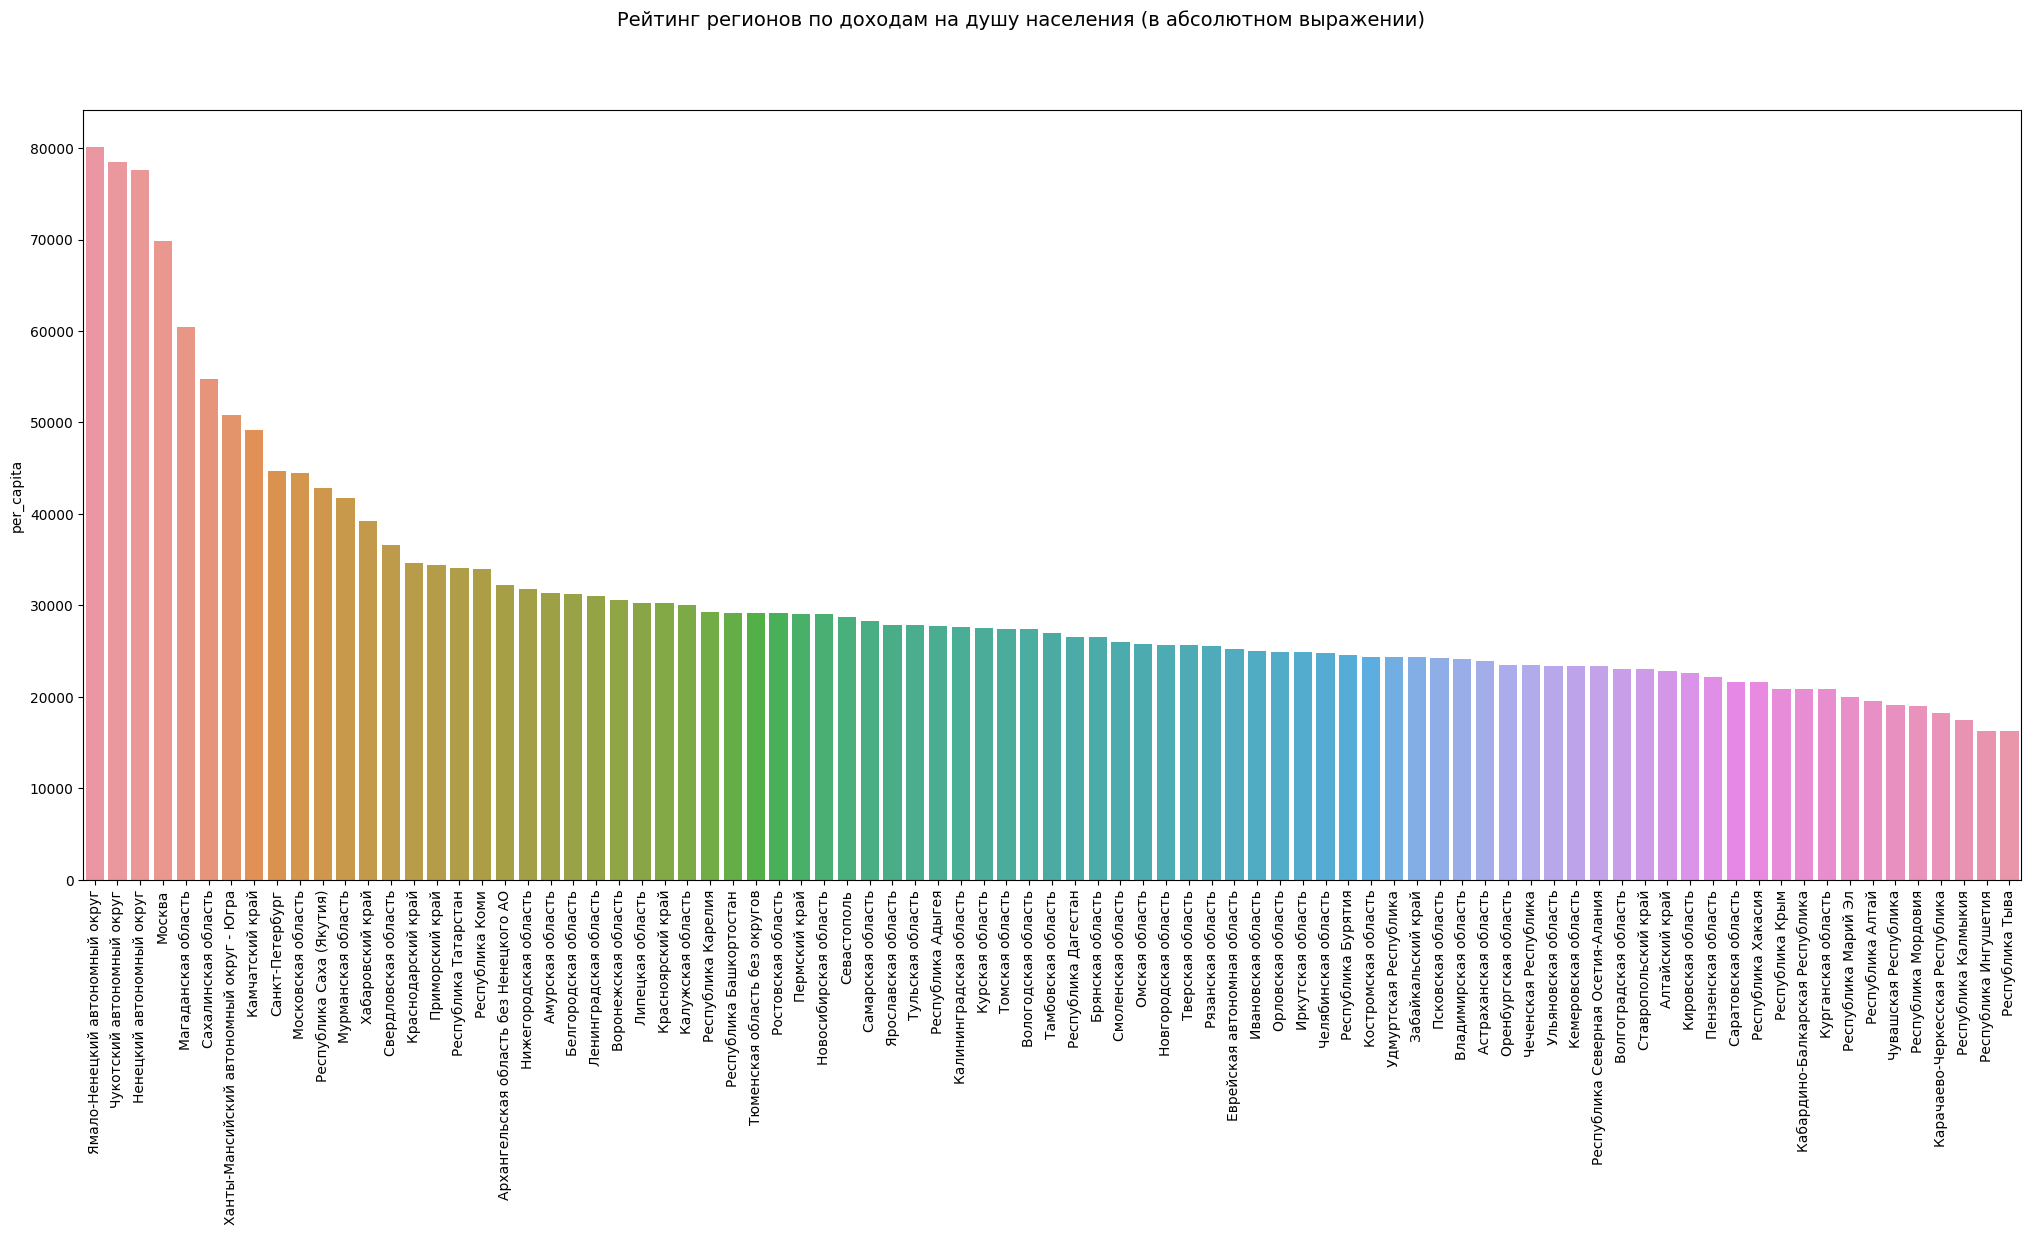

In [73]:
plot_df = model_df.sort_values(by='per_capita', ascending=False)
fig = plt.figure(figsize=(25,10))
sns.barplot(data=plot_df, x=plot_df.index, y='per_capita')
fig.suptitle(
    'Рейтинг регионов по доходам на душу населения (в абсолютном выражении)',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);

 Москва оказывается на 4-м, а Санкт-Петербург на 9-м месте, в то время как Ямало-Ненецкий АО занимает первое место. Это  связано с высокими доходами на предприятиях ТЭК, так же как и в некоторых других регионах. 

#### 2.1.4. Распределения признаков

In [74]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   per_capita              85 non-null     float64
 1   nominal_salary          85 non-null     float64
 2   gross_regional_product  85 non-null     float64
 3   living_area             85 non-null     float64
 4   poverty_percent         85 non-null     float64
 5   regional_production     85 non-null     float64
 6   retail                  85 non-null     float64
 7   living_wage             85 non-null     float64
dtypes: float64(8)
memory usage: 6.0+ KB


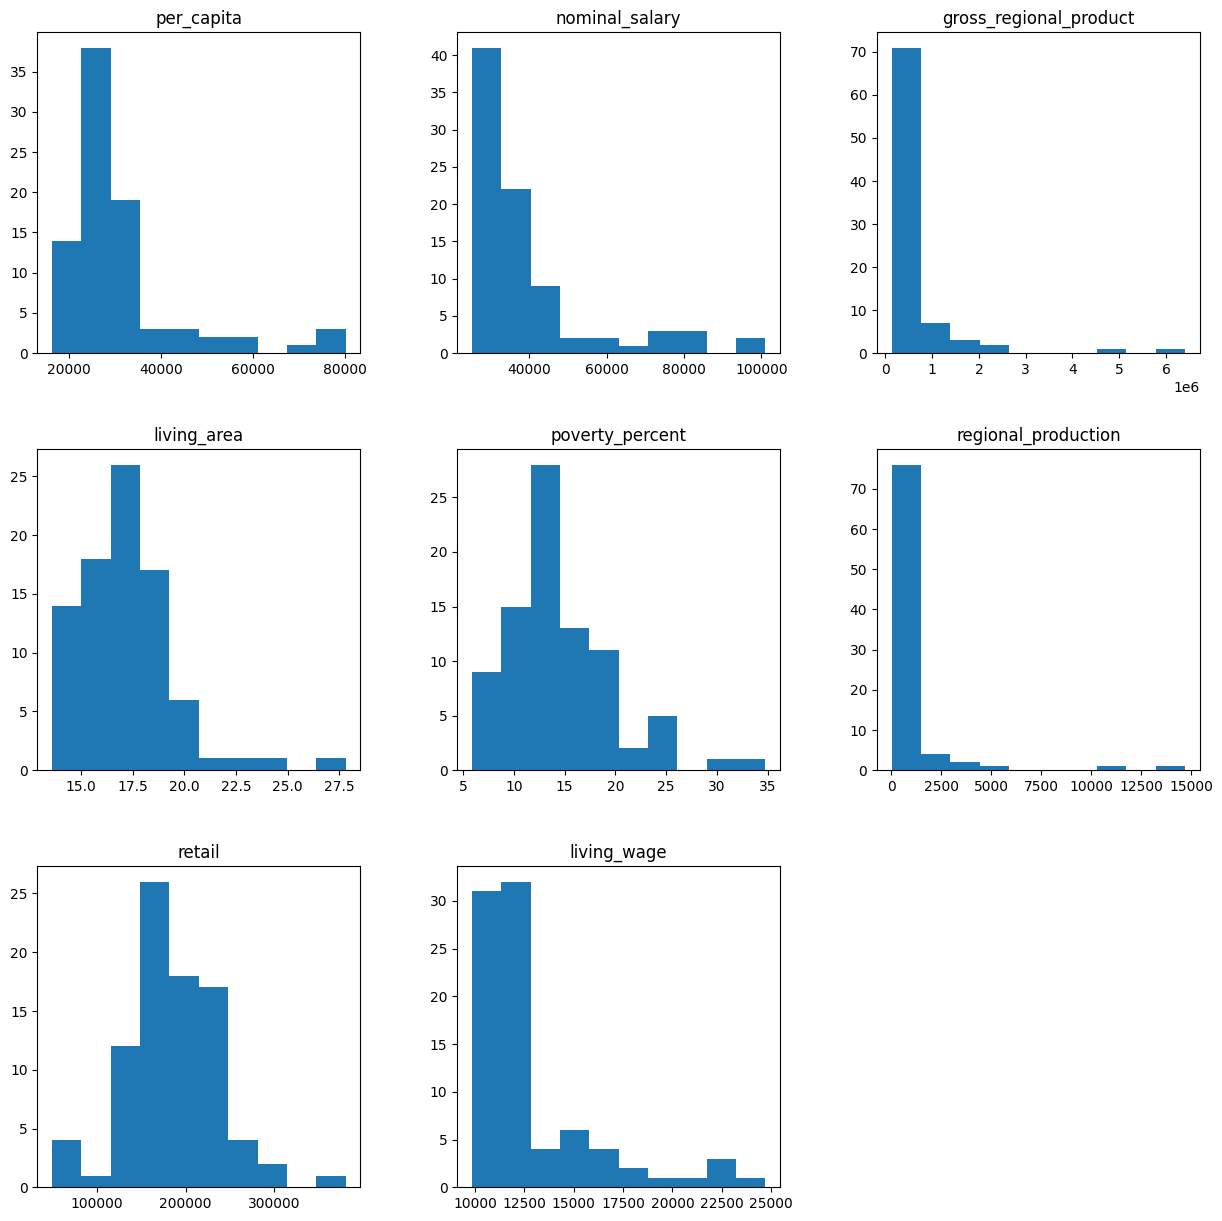

In [75]:
# Визуализируем распределение признаков
model_df.hist(figsize = (15,15), grid = False);
plt.show()

Не все гистограммы имеют симметричный вид, что подтверждает наличие нескольких групп признаков 

#### 2.1.5. Корреляции

Построим корреляционную матрицу. В связи с тем, что признаки распределены не нормально, рассмотрим ранговые критерии Спирмена и Кендалла.

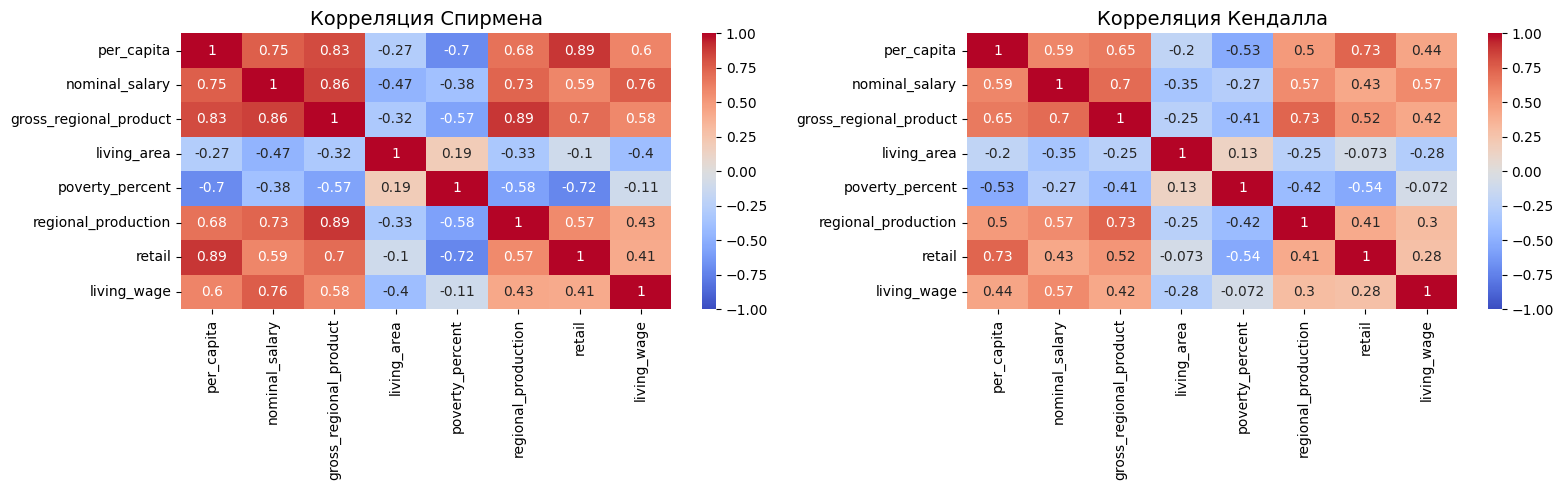

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();

Из матрицы корреляций видим:
per_capita c retail имеет сильную связь (0.73)
gross_regional_product c regional_production имеет сильную связь (0.73)
gross_regional_product c nominal_salary имеет сильную связь (0.7)
retail c poverty_procent имеет достаточно сильную обратную корреляцию(-0.54)

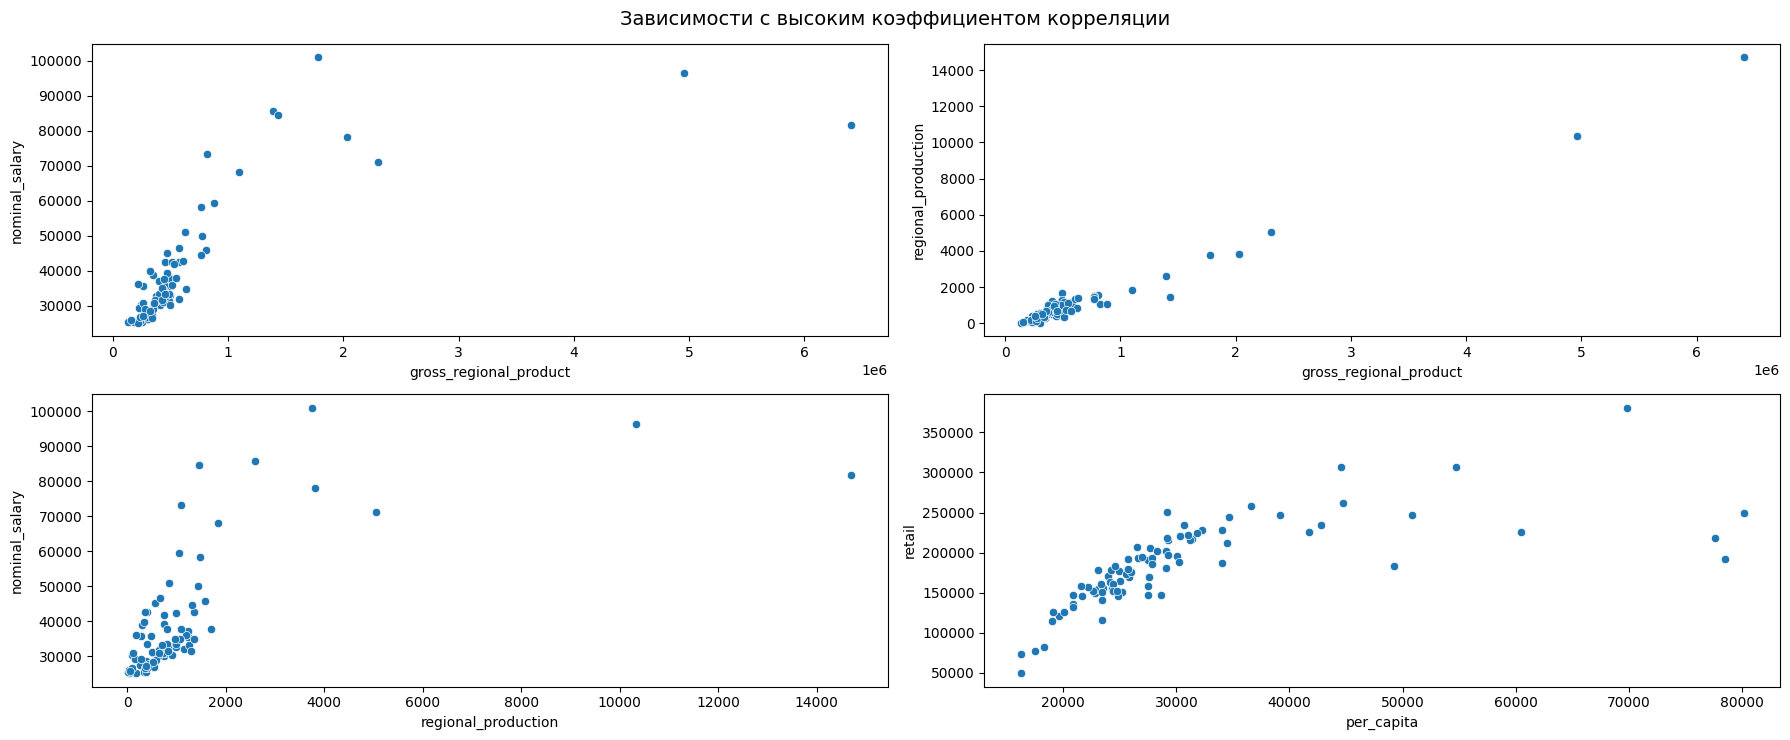

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(18, 7.5))
sns.scatterplot(
    data=model_df, x= 'gross_regional_product', y ='nominal_salary', ax=ax[0, 0])
sns.scatterplot(
    data=model_df, x= 'gross_regional_product', y ='regional_production', ax=ax[0, 1])
sns.scatterplot(
    data=model_df, x= 'regional_production', y ='nominal_salary', ax=ax[1, 0])
sns.scatterplot(
    data=model_df, x= 'per_capita', y ='retail', ax=ax[1, 1])

plt.suptitle('Зависимости с высоким коэффициентом корреляции', fontsize=14)
plt.tight_layout();


Некоторые  из имеющихся зависимостей вполне понятны: ВРП непосредственно связан с производством в регионе, а уровень бедности - с доходом на душу населения. Следовательно, дублеров следует исключить. Также, у нас есть признаки, где связь не так очевидна, например ВРП (log_grp) и среднуюю зарплату (nominal_salary_norm).  Мы отсекаем признаки, скоррелированные по критерию Кендалла.

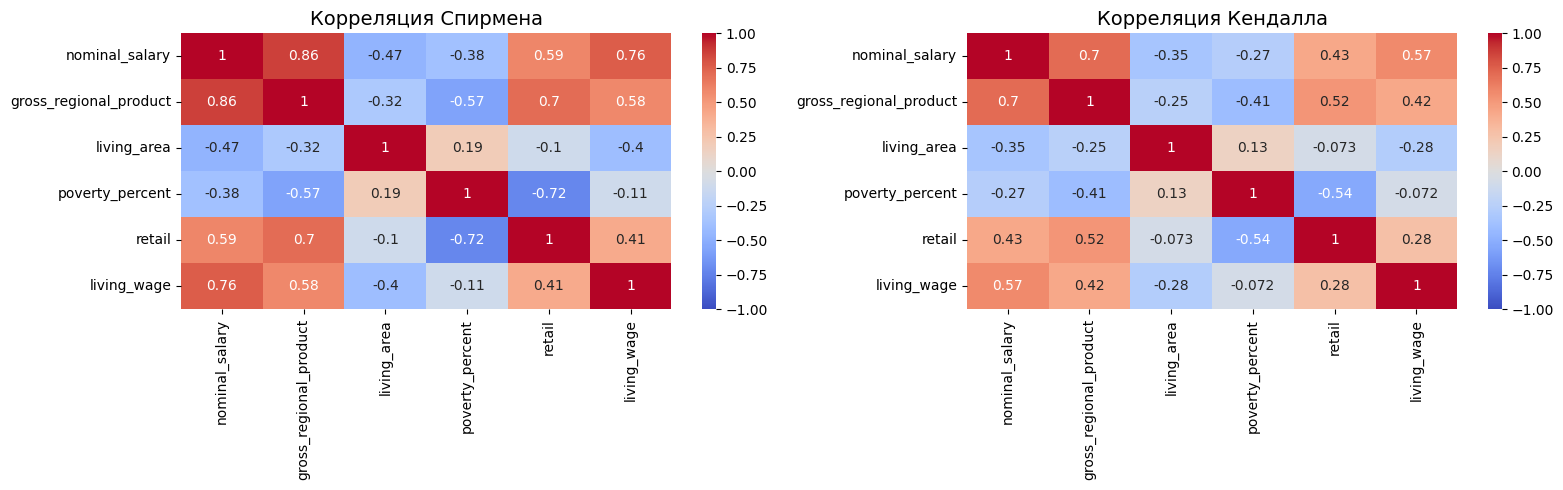

In [78]:
model_df.drop(
    columns=['regional_production', 'per_capita'], 
    axis=1, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();

#### 2.1.6. Масштабирование

Масштабируем признаки по минимальным и максимальным значениям.

In [79]:
scaler = MinMaxScaler()
X = scaler.fit_transform(model_df)

### 2.2. Кластеризация

#### 2.2.1. Базовая модель: k-means

В качестве базовой модели используем k-means. 

Выбираем количество кластеров.

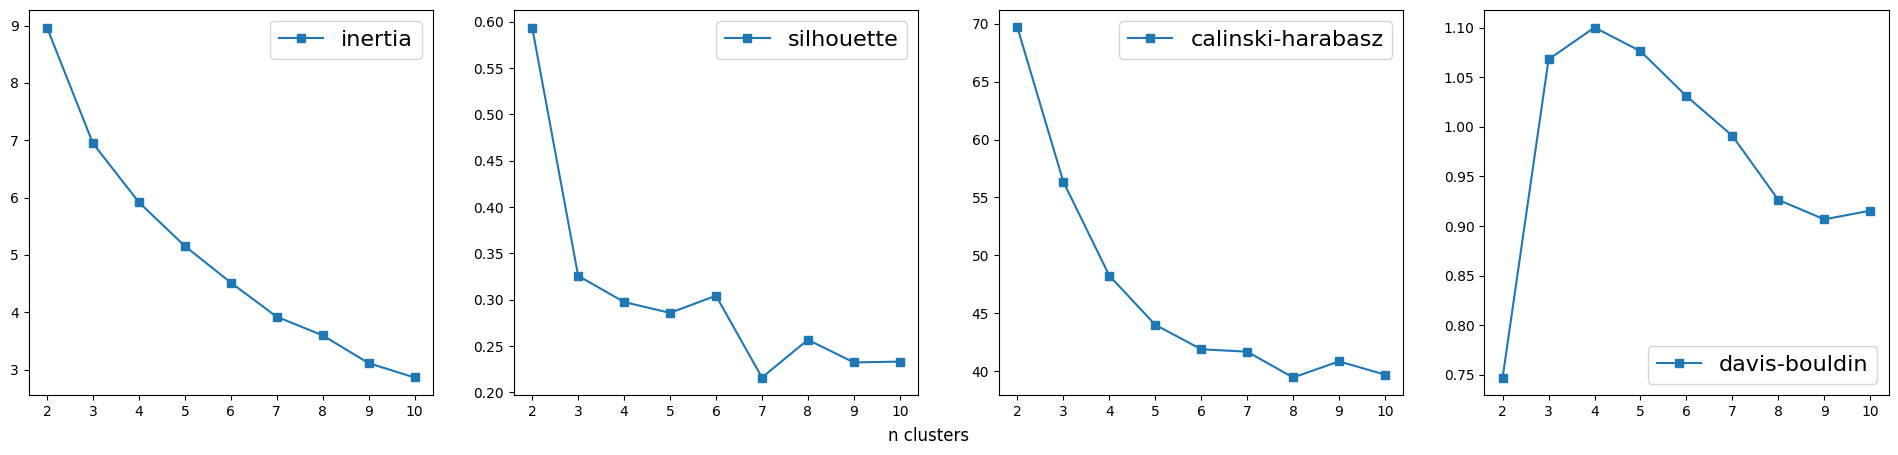

In [80]:
def plot_metrics(X):
    """Plot clustering metrics depending on the number of clusters"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    
        
plot_metrics(X)

Разделение кластеров совершенно нечеткое (коэффициент силуэта везде меньше 0.6, наибольшее значение при минимальном количестве кластеров). Тем не менее, ориентируясь на метод локтя (inertia), примем количество кластеров равным 4. Визуализируем с помощью t-SNE преобразования пятимерного признакового пространства на плоскость. Выводим значения метрик качества кластеризации.

In [97]:
from sklearn.cluster import KMeans
# Используем метод кластеризации KMeans
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(X)

y_kmeans = kmeans.predict(X)


Silhouette: 0.298
Calinski-Harabatz: 48.241
Davis-Bouldin: 1.100


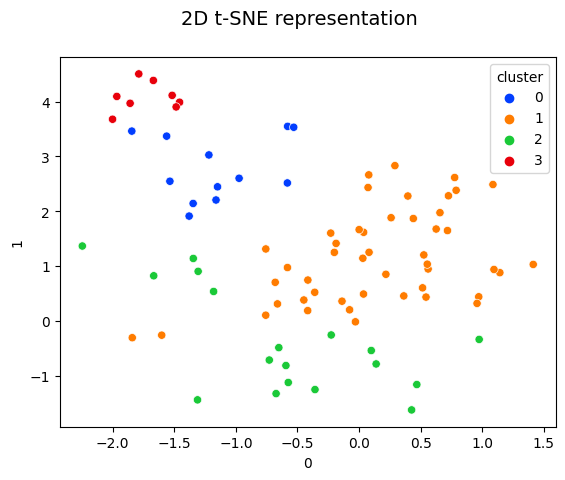

In [168]:
def plot_results(X, labels):
    "Plotting a 2D t-SNE representation and calculated metrics"
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('2D t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=4, random_state=42)
labels_k_means = kmeans.fit_predict(X)
plot_results(X, labels_k_means)

По графику видим, что результаты кластеризации оставляют желать лучшего.

#### 2.2.2. Понижение размерности. PCA + k-means

Число главных компонент: 3


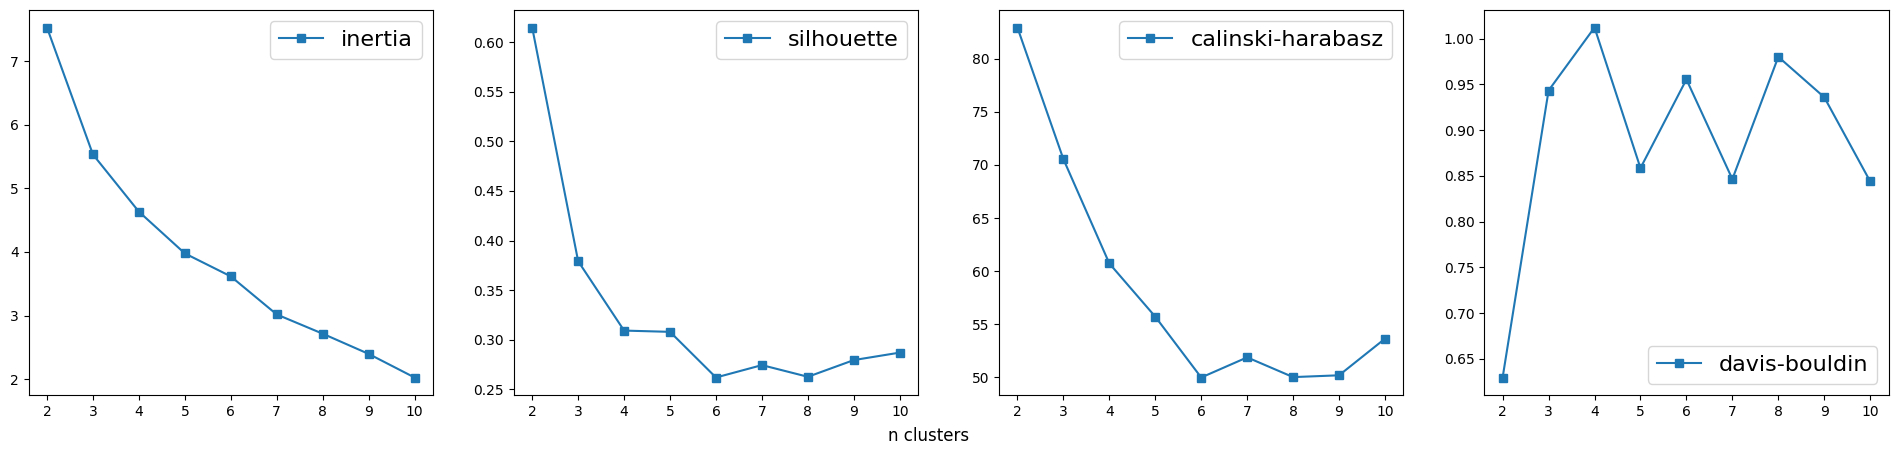

In [99]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

Мы видим, что 90% объясненной дисперсии зависит всего от 3 главных компонент.

Коэффициент силуэта показывает лучший результат при количестве кластеров n=3. По коэффициенту davis-bouldin и коэффициенту calinski-harabasz лучше взять n=3. Заметно, что метрики в целом показывают лучшее качество, чем у базовой модели.

Silhouette: 0.379
Calinski-Harabatz: 70.553
Davis-Bouldin: 0.943
Rand score (сравнение с базовой моделью): 0.817367


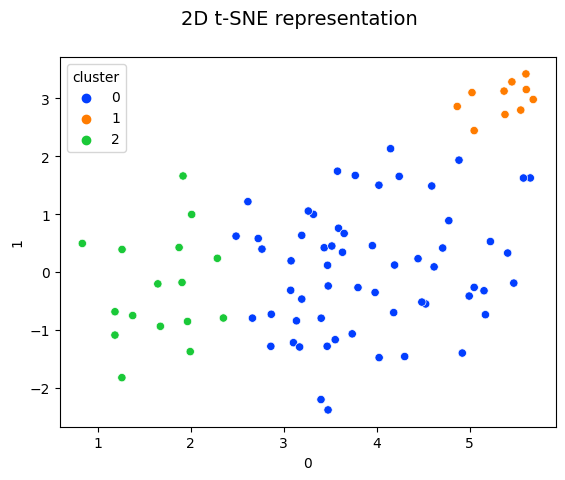

In [169]:
kmeans_pca = cluster.KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(labels_k_means, kmeans_pca.labels_)))

2.2.3. Тестирование различных алгоритмов кластеризации, валидация
Используем данные после PCA-преобразования: массив X_pca. Количество кластеров оставляем равным трем.

Silhouette: 0.529
Calinski-Harabatz: 57.995
Davis-Bouldin: 0.812
Rand score (сравнение с базовой моделью): 0.606162


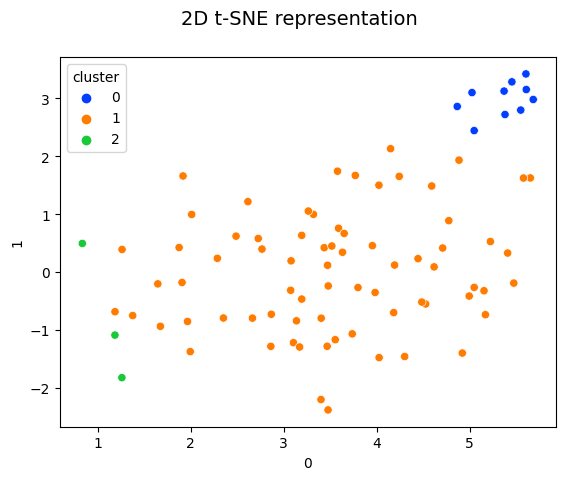

In [174]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=3, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(labels_k_means, labels)))

Silhouette: 0.371
Calinski-Harabatz: 69.440
Davis-Bouldin: 0.957
Rand score (сравнение с базовой моделью): 0.817367


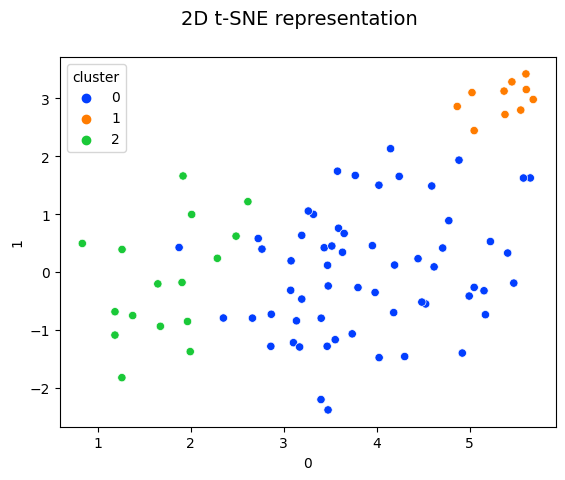

In [175]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(labels_k_means, labels)))

Silhouette: 0.349
Calinski-Harabatz: 52.371
Davis-Bouldin: 1.182
Rand score (сравнение с базовой моделью): 0.615126


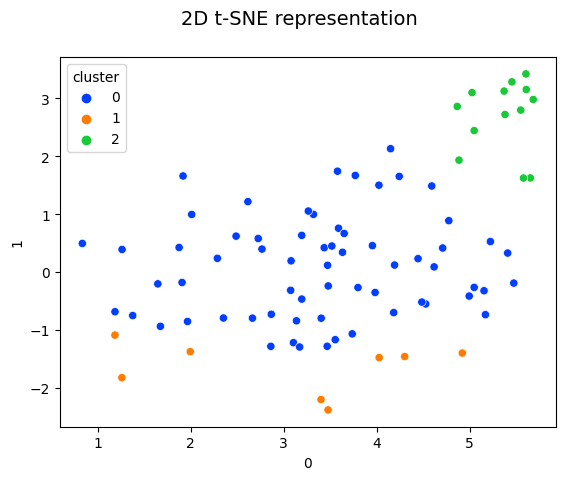

In [176]:
# Распространение сходства
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(labels_k_means, labels)))

Silhouette: 0.356
Calinski-Harabatz: 68.181
Davis-Bouldin: 0.966
Rand score (сравнение с базовой моделью): 0.849860


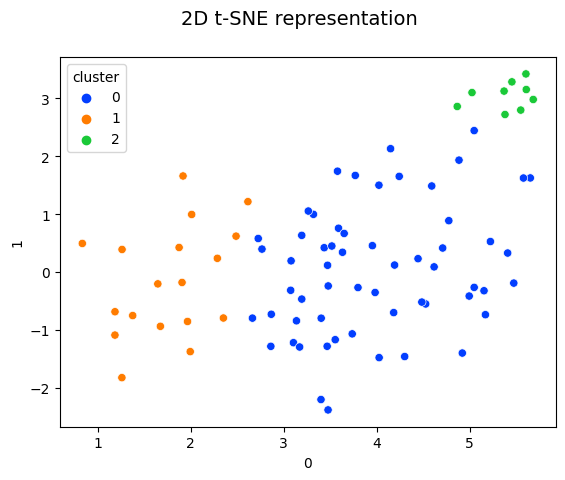

In [178]:
spectral = cluster.SpectralClustering(n_clusters=3)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(labels_k_means, labels)))

Выводы по результатам тестирования и валидации

SpectralClustering показывает наилучшие метрики (индекс Рэнда).Также отличные результаты показала AgglomerativeClustering. Но  наилучшие коэффициенты Silhouette, Calinski-Harabatz и Davis-Bouldin у метода k-means на PCA-признаках. Ориентируясь на коэффициенты и визуализацию результата кластеризации в пространстве PCA-компонент (ниже), в качестве окончательной модели выбираем "метод k-means на PCA-признаках". Отметим, что в качестве альтернативного метода разбиения выборки на кластеры можно использовать SpectralClustering.

Также отметим, что индексы Рэнда при сравнении с базовой моделью остаются достаточно высокими, что говорит об устойчивости общей структуры распределения объектов по кластерам при использовании разных алгоритмов. Вариации индекса Рэнда объясняются различными перераспределениями "граничных" (между кластерами) точек. Это хорошо демонстрируется визуализацией результатов с посщью tSNE. Таким образом, можно сделать вывод, что общая структура полученных кластеров довольно устойчива.

#### 2.2.3. Интерпретация результатов кластеризации

In [104]:
df['cluster'] = kmeans_pca.labels_


df.to_csv('data/russia_regions_clusters.csv')
df['cluster'].to_csv('data/labels.csv')


In [105]:
#Посчитаем количество регионов в каждом из кластеров
df['cluster'].value_counts().sort_index()

0    59
1    10
2    16
Name: cluster, dtype: int64

In [106]:
#Посмотрим на описание кластера 0:
df[df['cluster'] == 0].describe()

,population,per_capita,nominal_salary,child_mortality,disabled_18_60,alco,drug,general_morbidity,congenital_malformation,psychosis,...,no_funds,birth_rate,poverty_percent,poor_children,poor_aged,poor_employable,regional_production,retail,living_wage,cluster
count,5.900000e+01,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,1.959985e+06,28254.440678,34538.427119,0.524809,57659.25000,64.775424,10.427684,78527.988983,220.397740,481.905932,...,1.017842,1051.738403,13.002373,38.420339,5.618644,55.969492,755.785537,191193.084746,11956.355932,0.0
std,1.422877e+06,4896.526058,7123.745528,0.091362,42118.09226,26.296876,7.169010,13774.270425,126.902056,146.583129,...,1.344505,150.382954,2.786002,6.175725,3.526328,5.525965,390.777729,35136.507242,1459.315200,0.0
min,4.348072e+05,21654.800000,25180.400000,0.346764,7769.50000,14.850000,0.450000,51587.800000,41.200000,215.300000,...,0.000000,791.506410,6.880000,19.000000,0.800000,42.300000,46.260038,140139.200000,9834.000000,0.0
25%,1.014382e+06,24683.900000,29696.400000,0.466879,27804.62500,46.650000,5.683333,69167.450000,116.100000,375.700000,...,0.145500,932.829127,10.960000,34.450000,3.350000,53.000000,430.873266,161918.100000,10943.000000,0.0
50%,1.329110e+06,27535.400000,32909.600000,0.521007,42463.25000,62.200000,8.833333,76264.950000,197.533333,448.600000,...,0.607700,1026.601302,13.520000,39.200000,4.800000,55.400000,736.175030,186367.600000,11643.000000,0.0
75%,2.655315e+06,30289.500000,37551.100000,0.581517,78666.62500,82.200000,11.900000,88280.450000,285.283333,582.100000,...,1.264850,1138.058418,14.540000,42.050000,6.850000,59.250000,1029.643414,215873.400000,12431.500000,0.0
max,7.507202e+06,44713.200000,59480.600000,0.840775,214729.50000,134.500000,41.900000,111896.450000,551.500000,856.450000,...,6.588600,1587.812954,19.480000,49.900000,18.400000,69.200000,1693.607033,307147.800000,16510.000000,0.0


In [114]:
df[df['cluster'] == 0]['gross_regional_product'].mean()
df[df['cluster'] == 0]['living_area'].mean()

17.1728813559322

Кластер 0 - наиболее многочисленный кластер "среднестатистических регионов". Средние показатели : зарплата 28254 руб, валовый региональный продукт около 441 т.р., годовой объем розничной торговли 191193 руб, жилплощадь около 17.2 кв.м, 13% населения за чертой бедности.

In [107]:
# Выведем регионы, входящие в кластер 0:
df[df['cluster'] == 0].index

Index(['Амурская область', 'Архангельская область без Ненецкого АО',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область', 'Вологодская область',
       'Воронежская область', 'Ивановская область', 'Иркутская область',
       'Калининградская область', 'Калужская область', 'Кемеровская область',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курская область', 'Ленинградская область',
       'Липецкая область', 'Московская область', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       'Оренбургская область', 'Орловская область', 'Пензенская область',
       'Пермский край', 'Приморский край', 'Псковская область',
       'Республика Адыгея', 'Республика Башкортостан', 'Республика Бурятия',
       'Республика Дагестан', 'Республика Карелия', 'Республика Коми',
       'Республика Северная Осетия-Алания', 'Ре

In [108]:
#Посмотрим на описание кластера 1:
df[df['cluster'] == 1].describe()

,population,per_capita,nominal_salary,child_mortality,disabled_18_60,alco,drug,general_morbidity,congenital_malformation,psychosis,...,no_funds,birth_rate,poverty_percent,poor_children,poor_aged,poor_employable,regional_production,retail,living_wage,cluster
count,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.00000,10.000000,10.000000,10.0000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,1.745270e+06,60586.000000,79909.700000,0.563965,38519.050000,112.550000,8.280000,94489.430000,276.676667,608.840000,...,2.31672,1230.165037,10.504000,44.3600,5.520000,50.140000,4613.161013,246450.880000,20151.600000,1.0
std,3.811209e+06,14943.319907,12942.364179,0.285388,88521.458912,69.080206,5.569742,24026.787202,230.679988,277.268005,...,2.33549,178.439304,3.921913,6.7031,4.983484,4.797731,4474.275145,58229.173743,2749.469371,0.0
min,4.394240e+04,41757.600000,58362.600000,0.366300,1062.750000,22.466667,0.666667,63887.450000,65.166667,291.050000,...,0.00000,982.005208,5.860000,30.7000,0.400000,42.900000,1087.193057,183505.600000,17140.000000,1.0
25%,1.863154e+05,49602.900000,71760.450000,0.399472,3489.812500,63.816667,4.325000,80108.287500,176.225000,475.575000,...,0.00000,1088.772617,8.535000,42.8750,1.700000,48.425000,1570.558868,219871.650000,17661.750000,1.0
50%,5.137336e+05,57574.900000,79996.300000,0.491876,8725.375000,110.050000,8.766667,87478.750000,225.600000,509.050000,...,1.89165,1229.981681,9.660000,44.5500,3.900000,50.550000,3174.013102,230395.900000,19556.500000,1.0
75%,9.120194e+05,75676.750000,85489.150000,0.545854,23490.250000,145.566667,10.741667,111381.725000,279.566667,640.300000,...,4.37350,1370.084330,10.665000,46.5750,10.100000,52.175000,4746.830952,249091.950000,22408.000000,1.0
max,1.250212e+07,80159.800000,101050.800000,1.327580,288855.000000,264.600000,17.866667,140189.450000,901.433333,1142.850000,...,5.81280,1491.042820,18.620000,55.6000,13.200000,57.800000,14708.467087,380821.800000,24711.000000,1.0


Кластер 1 - "премиум-регионы": Москва, Санкт-Петербург, ЯНАО, ХМАО, Сахалин, Якутия, Чукотка. Наиболее высокие зарплаты(60586 руб), ВРП высоченный , самый низкий уровень бедности(10.5%). Одновременно с этим - средние показатели розничной торговли(246450)

In [118]:
# Выведем регионы, входящие в кластер 1:
df[df['cluster'] == 1].index

Index(['Камчатский край', 'Магаданская область', 'Москва',
       'Мурманская область', 'Ненецкий автономный округ',
       'Республика Саха (Якутия)', 'Сахалинская область',
       'Ханты-Мансийский автономный округ - Югра',
       'Чукотский автономный округ', 'Ямало-Ненецкий автономный округ'],
      dtype='object', name='region')

In [119]:
#Посмотрим на описание кластера 2:
df[df['cluster'] == 2].describe()

,population,per_capita,nominal_salary,child_mortality,disabled_18_60,alco,drug,general_morbidity,congenital_malformation,psychosis,...,no_funds,birth_rate,poverty_percent,poor_children,poor_aged,poor_employable,regional_production,retail,living_wage,cluster
count,1.600000e+01,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0
mean,8.537468e+05,20373.587500,29776.10000,0.635774,34224.125000,64.155208,12.266667,74555.546875,230.500000,474.065625,...,0.995150,1285.885147,22.406250,36.300000,5.750000,57.950000,273.511556,119513.175000,11615.000000,2.0
std,6.217000e+05,2683.070675,5246.55914,0.201517,30505.371248,31.911979,16.499148,18079.141124,168.205544,318.215170,...,1.623628,365.807929,4.713242,7.383947,3.603517,6.559472,216.893002,32807.494811,1516.678608,0.0
min,1.621138e+05,16234.600000,25286.80000,0.328407,5186.750000,0.100000,0.350000,45707.200000,45.133333,104.450000,...,0.000000,823.734742,17.560000,22.200000,0.300000,50.100000,20.521747,49174.200000,10079.000000,2.0
25%,4.301295e+05,18837.100000,25865.15000,0.495524,13723.250000,50.787500,2.637500,65544.237500,112.950000,281.912500,...,0.000000,1077.950828,18.855000,32.450000,2.550000,52.550000,97.790628,106700.950000,10823.000000,2.0
50%,7.419430e+05,20445.300000,27530.70000,0.604004,28499.750000,74.733333,7.700000,68269.675000,184.183333,386.525000,...,0.348800,1137.154934,21.170000,35.350000,6.000000,57.800000,238.790099,125833.800000,11171.000000,2.0
75%,1.111284e+06,21897.200000,31832.95000,0.726840,34859.062500,83.441667,14.908333,90195.950000,286.408333,569.075000,...,1.655675,1344.184719,24.305000,43.325000,7.700000,61.275000,360.087859,147842.050000,11825.750000,2.0
max,2.348500e+06,25218.800000,39862.00000,1.086138,129712.500000,114.600000,68.400000,111208.650000,675.833333,1369.900000,...,6.374400,2094.712060,34.760000,48.200000,12.100000,73.600000,811.236850,157649.600000,16336.000000,2.0


Кластер 2  - кластер самых бедных регионов. Самые низкие заработки(20373 руб), ВРП, объемы розничной торговли (119513 руб)  и самый высокий процент населения за чертой бедности(22.4%).  

In [120]:
# Выведем регионы, входящие в кластер 2:
df[df['cluster'] == 2].index

Index(['Алтайский край', 'Еврейская автономная область', 'Забайкальский край',
       'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика',
       'Курганская область', 'Республика Алтай', 'Республика Ингушетия',
       'Республика Калмыкия', 'Республика Крым', 'Республика Марий Эл',
       'Республика Мордовия', 'Республика Тыва', 'Республика Хакасия',
       'Чеченская Республика', 'Чувашская Республика'],
      dtype='object', name='region')

#### 2.2.4. Проверка гипотез о влиянии числа детей, пенсионеров на уровень бедности

In [122]:
cols =[
    'poor_children',
    'poor_employable', 
    'poor_aged']
df[cols].mean()

poor_children      38.720000
poor_employable    55.656471
poor_aged           5.631765
dtype: float64

Оценим соотношение малоимущих в социально-демографических группах по кластерам

In [124]:
socgroups = df[[
    'population', 'poverty_percent', 'poor_children',
    'poor_aged', 'poor_employable']].copy()



In [135]:
socgroups['cluster'] = df['cluster']
cluster_socgroups = (socgroups
    .groupby('cluster')[['poor_children', 'poor_employable', 'poor_aged']].mean())
cluster_socgroups


,poor_children,poor_employable,poor_aged
cluster,,,
0,38.420339,55.969492,5.618644
1,44.360000,50.140000,5.520000
2,36.300000,57.950000,5.750000


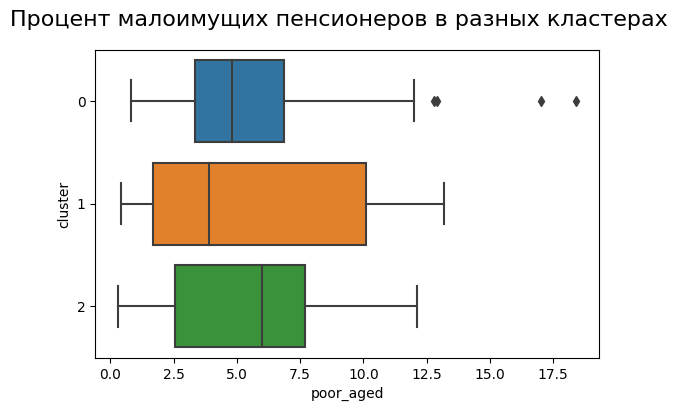

In [161]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='poor_aged', y='cluster', orient='h')
fig.suptitle('Процент малоимущих пенсионеров в разных кластерах',fontsize=16);

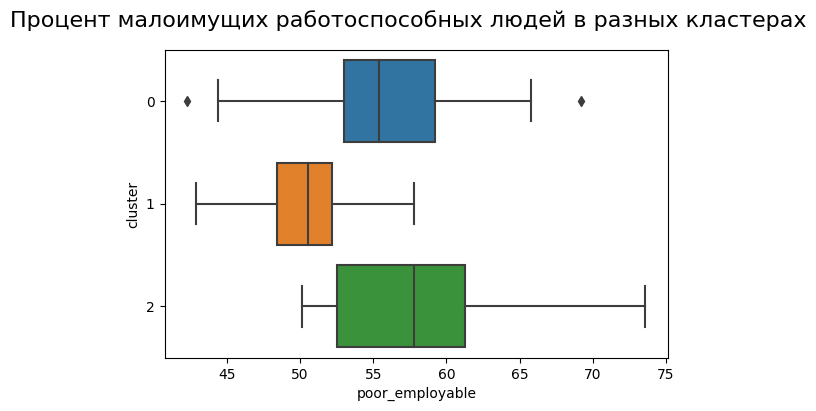

In [163]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='poor_employable', y='cluster', orient='h')
fig.suptitle('Процент малоимущих работоспособных людей в разных кластерах',fontsize=16);

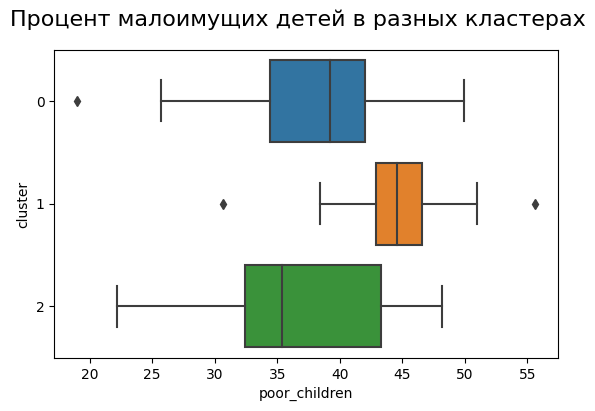

In [160]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='poor_children', y='cluster', orient='h')
fig.suptitle('Процент малоимущих детей в разных кластерах',fontsize=16);

Из таблицы и графиков выше видим, что существенных отличий по представителям пенсионного возраста за чертой бедности не наблюдается.
Наблюдаются небольшие отличия в процентах распределения работоспособного населения, находящегося  за чертой бедности: величины колеблются в пределах 50% - 58% (Закономерно, в богатых регионах чуть ниже(50%), в средних-чуть выше(55%), и в бедных самый высокий(58%)).
Одновременно можно отметить, что в беднейших регионах не наблюдается существенного роста процента неблагополучных детей, и даже наоборот,процент неблагополучных детей в целом не падает с ростом финансового благополучия, а растет.  
Проверим гипотезу о том, что в более бедных регионах выше рождаемость, что оказывает дополнительное негативное влияние на показатели дохода на душу населения. Посмотрим на показатели рождаемости (график ниже).

In [143]:
def kruskal_pvalue(df, col):
    "p-value для заданной колонки (значимость различий по 3-м кластерам)"
    v0 = df[df['cluster'] == 0][col]
    v1 = df[df['cluster'] == 1][col]
    v2 = df[df['cluster'] == 2][col]
    _, p = kruskal(v0, v1, v2)
    return p

Нулевая гипотеза: рождаемость не зависит от кластера
Kruskal-Wallis p-value = 0.001


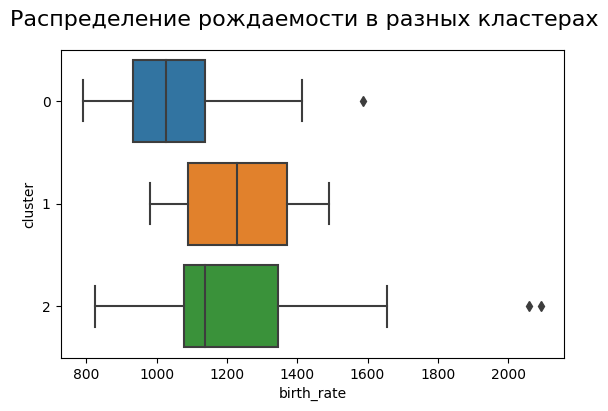

In [145]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='birth_rate', y='cluster', orient='h')
fig.suptitle('Распределение рождаемости в разных кластерах',fontsize=16);

print('Нулевая гипотеза: рождаемость не зависит от кластера')
print(f"Kruskal-Wallis p-value = {kruskal_pvalue(df, 'birth_rate'):.3f}")

Видим, что действительно кластер беднейших регионов показывает максимальную рождаемость (в расчете на 100 тыс. населения), однако в двух других кластерах тенденция противоположная: В среднестатистических регионах рождаемость ниже, и растет с ростом благосостояния. Делаем вывод, что в беднейших регионах присутствует особая атмосфера: высокая рождаемость, неподкрепленная доходами родителей.
 
А в богатых регионах уровень благосостояния нивелируется высоким прожиточным минимумом, что в целом по стране делает картину более или менее равномерной.

#### 2.2.5. Прочие отличия между кластерами

Рассмотрим прочие отличия между кластерами. Для этого выберем признаки, которые еще не рассматривались, из них выберем только те, которые показывают статистически значимые различия между кластерами на уровне 5% по критерию Краскела-Уоллиса.  

In [148]:
cols = [
    'child_mortality', 'disabled_18_60', 'alco', 'drug', 
    'bad_conditions', 'no_funds', 'general_morbidity', 
    'congenital_malformation', 'psychosis', 
    'teenage_pregnancy', 'population', 'living_wage'
]

cols_s = cols.copy()
for col in cols:
    p = kruskal_pvalue(df, col)
    print(f'{col}:   p-value = {p:.3f}')
    if p > 0.05: 
        cols_s.remove(col)

child_mortality:   p-value = 0.069
disabled_18_60:   p-value = 0.000
alco:   p-value = 0.059
drug:   p-value = 0.766
bad_conditions:   p-value = 0.277
no_funds:   p-value = 0.451
general_morbidity:   p-value = 0.061
congenital_malformation:   p-value = 0.745
psychosis:   p-value = 0.237
teenage_pregnancy:   p-value = 0.115
population:   p-value = 0.000
living_wage:   p-value = 0.000


In [149]:
cols_s

['disabled_18_60', 'population', 'living_wage']

Кластеры не отличаются по следующим характеристикам:
'child_mortality', 'alco', 'drug', 'bad_conditions', 'no_funds', 'general_morbidity', 'congenital_malformation','psychosis', 'teenage_pregnancy'

Значимо различающиеся признаки:
'disabled_18_60','population', 'living_wage'


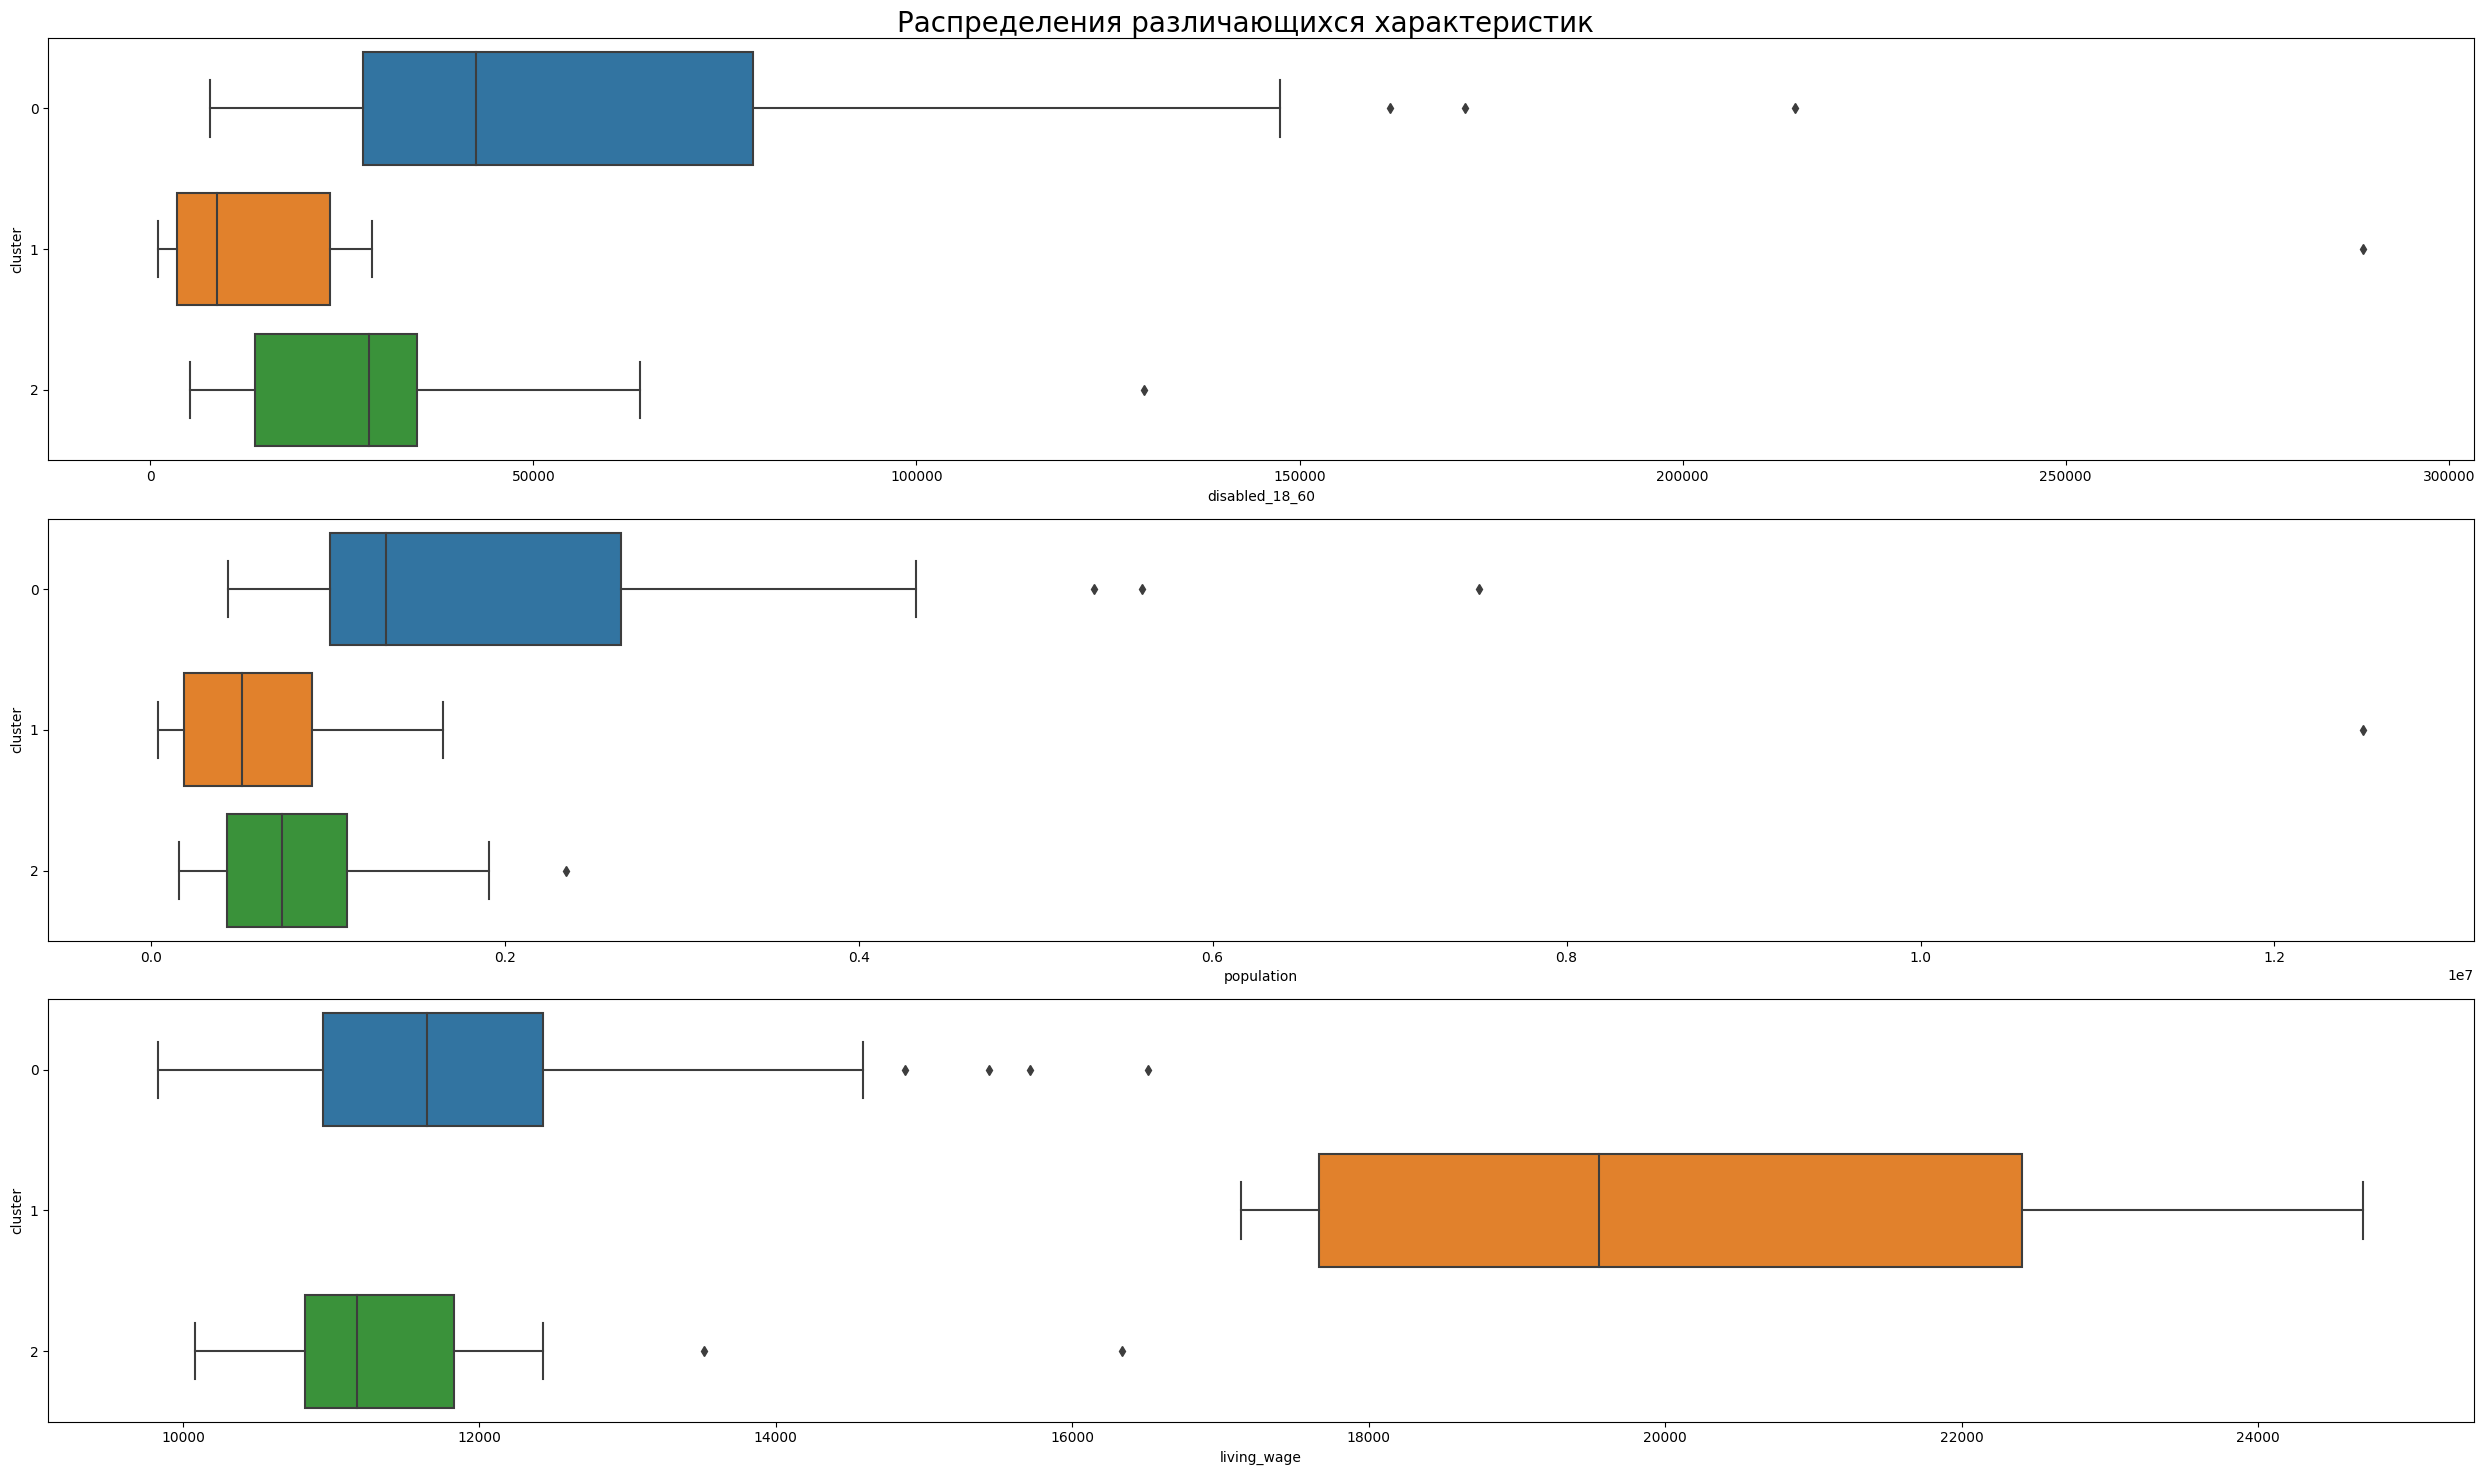

In [158]:
#Построим графики распределений для значимо отличающихся характеристик:
fig, ax = plt.subplots(3, figsize=(25, 15))
sns.boxplot(data=df, x='disabled_18_60', y='cluster', orient='h', ax=ax[0])
sns.boxplot(data=df, x='population', y='cluster', orient='h', ax=ax[1])
sns.boxplot(data=df, x='living_wage', y='cluster', orient='h', ax=ax[2])
fig.suptitle('Распределения различающихся характеристик',fontsize=20)
plt.tight_layout()

В среднестатистических регионах уровень инвалидности среди трудоспособного населения гораздо выше, нежели в богатых и бедных. Самый низкий уровень инвалидности в регионах  богатого кластера.
По численности населения также лидируют среднестатистические регионы, а вот прожиточный минимум в разы возрастает в богатых регионах.

### Выводы:

Из созданного нами датасета по регионам РФ в качестве критериев были выбраны признаки, отражающие социально-экономическое благополучие субъектов. 
Были построены рейтинги регионов по избранным показателям, исследованы распределения выбранных признаков и корреляция между ними, произведен отбор и выполнены необходимые преобразования. 

Было найдено оптимальное количество кластеров (4 кластера). Построена базовая модель (k-means). Выполнено PCA-понижение размерности (3 главных компоненты, объясняющие 90% дисперсии). 
Получены описательные характеристики кластеров и по ним сделана классификация регионов по уровню социально-экономического благополучия.
Было выяснено, влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе и рассмотрены другие зависимости относительно социально незащищенных групп населения.